In [1]:
import segmentation_models as sm
from sklearn.model_selection import train_test_split

from brainseg.generator import TrainGenerator, TestGenerator
from brainseg.loader import Loader
from brainseg.utils import load_data, show_batch_bires
from brainseg.image_provider import BiResImageHandler
from brainseg.provider import provider, DataHandler
from brainseg.streamlit.manager import list_all
from brainseg.slidedata.slides import find_slides_in_dir
from brainseg.slidedata.patch import create_patch, save_patch, load_patch, exists_patch
from brainseg.slidedata.mask import exists_mask_as_image

import matplotlib.pyplot as plt
import numpy as np
import os
from os.path import basename
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
from tensorflow.keras.optimizers import Adam
from skimage.transform import resize
from brainseg.utils import to_color, rgb_to_multi
from PIL import Image
from pathlib import Path

sm.set_framework("tf.keras")

2022-08-18 14:41:45.030319: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/yujie/Documents/Program/elastix/lib:
2022-08-18 14:41:45.030340: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Segmentation Models: using `keras` framework.


In [2]:
STAIN = "NeuN"

root = Path("/media/yujie/LaCie/Data/CZI/atlas_folder_backup")

data_root = Path(f"/media/yujie/LaCie/Data/slidedata/mask_mashimoto/{STAIN}")

Path(data_root).mkdir(parents=True, exist_ok=True)

slides = find_slides_in_dir(root)
czis = list(filter(lambda x: STAIN in basename(x), slides))

### Generate patches

In [3]:
def generate_patches(slides, root):
    for slide_path in slides:
        if not exists_patch(root, slide_path, name="patch_x8_s224"):
            patches = create_patch(slide_path, 8, 224, 224)
            save_patch(root, slide_path, patches, name="patch_x8_s224")
            
generate_patches(czis, data_root)

### Load patches

In [4]:
def load_patches(slides, root):
    return sum([load_patch(root, slide_path, name="patch_x8_s224")
                for slide_path in slides if exists_mask_as_image(root, slide_path, "mask")], [])

patches = [("multi_slide_mask", {"downscales": [32], **x}) for x in load_patches(czis, data_root)]

In [5]:
len(patches)

1380

## Build Handler

In [6]:
from brainseg.slide_provider_top_left import MultiSlideMaskHandler

In [7]:
handler = MultiSlideMaskHandler(czis, data_root, "mask")

In [8]:
provider.register(handler)

In [9]:
patches[0]

('multi_slide_mask',
 {'downscales': [32],
  'slide_name': 'p6_M150_LHRH_022_IA022_NeuN.czi',
  'origin': (0, 0),
  'downsample': 8,
  'step': 224,
  'size': 224})

In [10]:
n = 3
img = provider.image(patches[n])
arr = provider.mask(patches[n])

0 0
335 0


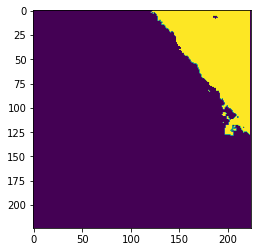

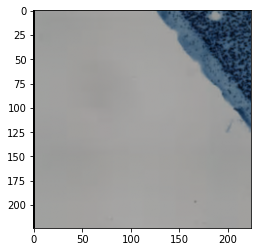

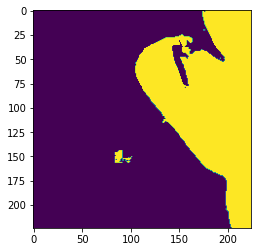

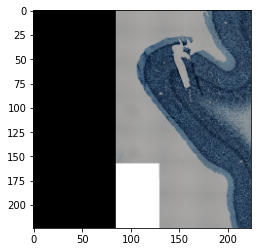

In [11]:
plt.imshow(arr[0])
plt.show()
plt.imshow(img[0] / 255.)
plt.show()
plt.imshow(arr[1])
plt.show()
plt.imshow(img[1] / 255.)

In [12]:
raise

RuntimeError: No active exception to reraise

In [ ]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.Rot90([0, 1, 2, 3]),
])

In [15]:
def preprocess_augment(x, y):
    x = np.asarray(x)
    y = np.asarray(y)

    # y = rgb_to_multi(y, colors)

    
    seg = SegmentationMapsOnImage(y, shape=y.shape)
    current_seq = seq.to_deterministic()
    
    x, y = current_seq(image=x, segmentation_maps=seg)
    
    x = x / 255.
    y = y.arr / 255.
    
    y = y.astype(np.float64)
    return x, y

In [16]:
def preprocess(x, y):
    x = np.asarray(x)
    x = x / 255.
    y = np.asarray(y) / 255.
    y = y.astype(np.float64)
    return x, y

In [17]:
train_dataset, test_dataset = train_test_split(patches, random_state=0)

In [18]:
train_gen = TrainGenerator(Loader(train_dataset), batch_size=4, preprocess=preprocess_augment)
test_gen = TestGenerator(Loader(test_dataset), batch_size=4, preprocess=preprocess)

In [ ]:
model = multires_unet(n_res=3, n_classes=1, im_sz=224, n_channels=3, n_filters_start=32,
                      growth_factor=1.2, all_outputs=True)

model.compile(
    Adam(learning_rate=1e-4),
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)

In [ ]:
for i in range(20):
    model.fit(train_gen, use_multiprocessing=True, workers=8)
    res = model.evaluate(test_gen)
    iou = "{:.3f}".format(res[1])
    model.save_weights(f"/media/yujie/LaCie/Data/models/{STAIN}/multi_model_x8_e{i}_iou{iou}.h5")

###### 